In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from math import ceil
import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('..')
from utils.input_pipeline import get_image_folders
from utils.training import train
from utils.quantization import optimization_step, quantize, initial_scales

torch.cuda.is_available()

True

In [3]:
torch.backends.cudnn.benchmark = True

In [4]:
LEARNING_RATE = 1e-3  # learning rate for all possible weights
HYPERPARAMETER_T = 0.05  # hyperparameter for quantization

# Create data iterators

In [5]:
batch_size = 512

In [6]:
train_folder, val_folder = get_image_folders()

train_iterator = DataLoader(
    train_folder, batch_size=batch_size, num_workers=4,
    shuffle=True, pin_memory=True
)

val_iterator = DataLoader(
    val_folder, batch_size=256, num_workers=4,
    shuffle=False, pin_memory=True
)

# number of training samples
train_size = len(train_folder.imgs)
train_size

100000

# Model

In [7]:
from get_densenet import get_model

In [8]:
model, loss, optimizer = get_model(learning_rate=LEARNING_RATE)

# load pretrained model, accuracy ~48%
model.load_state_dict(torch.load('../vanilla_densenet_small/model.pytorch_state'))

#### keep copy of full precision kernels

In [9]:
# copy almost all full precision kernels of the model
all_fp_kernels = [
    Variable(kernel.data.clone(), requires_grad=True) 
    for kernel in optimizer.param_groups[1]['params']
]
# all_fp_kernels - kernel tensors of all convolutional layers 
# (with the exception of the first conv layer)

#### initial quantization 

In [10]:
# scaling factors for each quantized layer
initial_scaling_factors = []

In [11]:
# these kernels will be quantized
all_kernels = [kernel for kernel in optimizer.param_groups[1]['params']]

In [12]:
for k, k_fp in zip(all_kernels, all_fp_kernels):
    
    # choose initial scaling factors 
    w_p_initial, w_n_initial = initial_scales(k_fp.data)
    initial_scaling_factors += [(w_p_initial, w_n_initial)]
    
    # do quantization
    k.data = quantize(k_fp.data, w_p_initial, w_n_initial, t=HYPERPARAMETER_T)

#### parameter updaters

In [13]:
# optimizer for updating only all_fp_kernels
optimizer_fp = optim.Adam(all_fp_kernels, lr=LEARNING_RATE)

In [14]:
# optimizer for updating only scaling factors
optimizer_sf = optim.Adam([
    Variable(torch.FloatTensor([w_p, w_n]).cuda(), requires_grad=True) 
    for w_p, w_n in initial_scaling_factors
], lr=LEARNING_RATE)

# Train

In [15]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

class lr_scheduler_list:
    """ReduceLROnPlateau for a list of optimizers."""
    def __init__(self, optimizer_list):
        self.lr_scheduler_list = [
            ReduceLROnPlateau(
                optimizer, mode='max', factor=0.1, patience=4, 
                verbose=True, threshold=0.01, threshold_mode='abs'
            ) 
            for optimizer in optimizer_list
        ]
    
    def step(self, test_accuracy):
        for scheduler in self.lr_scheduler_list:
            scheduler.step(test_accuracy)
        
n_epochs = 20
n_batches = ceil(train_size/batch_size)

# total number of batches in the train set
n_batches

196

In [16]:
%%time
optimizer_list=[optimizer, optimizer_fp, optimizer_sf]

def optimization_step_fn(model, loss, x_batch, y_batch):
    return optimization_step(
        model, loss, x_batch, y_batch, 
        optimizer_list=optimizer_list,
        t=HYPERPARAMETER_T
    )
all_losses = train(
    model, loss, optimization_step_fn,
    train_iterator, val_iterator, n_epochs,
    lr_scheduler=lr_scheduler_list(optimizer_list)
)
# epoch logloss  accuracy    top5_accuracy time  (first value: train, second value: val)

0  2.914 3.055  0.323 0.328  0.597 0.610  79.101
1  2.707 3.220  0.360 0.333  0.640 0.615  75.663
2  2.675 2.986  0.370 0.344  0.646 0.616  75.781
3  2.670 3.048  0.370 0.334  0.646 0.611  75.690
4  2.644 3.014  0.373 0.344  0.654 0.616  75.702
5  2.645 3.283  0.373 0.305  0.650 0.583  75.717
6  2.628 3.240  0.377 0.312  0.656 0.586  75.659
7  2.619 3.276  0.379 0.311  0.657 0.578  75.600
Epoch     7: reducing learning rate of group 0 to 1.0000e-04.
Epoch     7: reducing learning rate of group 1 to 1.0000e-04.
Epoch     7: reducing learning rate of group 2 to 1.0000e-04.
Epoch     7: reducing learning rate of group 3 to 1.0000e-04.
Epoch     7: reducing learning rate of group 4 to 1.0000e-04.
Epoch     7: reducing learning rate of group 0 to 1.0000e-04.
Epoch     7: reducing learning rate of group 0 to 1.0000e-04.
8  2.512 2.805  0.399 0.380  0.678 0.660  75.635
9  2.482 2.810  0.406 0.371  0.681 0.644  75.663
10  2.478 2.745  0.405 0.384  0.684 0.656  75.628
11  2.470 2.674  0.409 0.3

# Loss/epoch plots

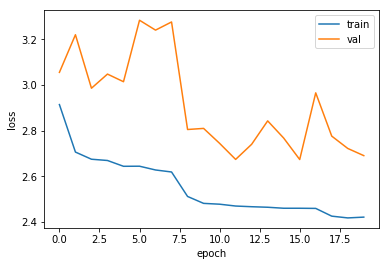

In [17]:
epochs = [x[0] for x in all_losses]
plt.plot(epochs, [x[1] for x in all_losses], label='train');
plt.plot(epochs, [x[2] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('loss');

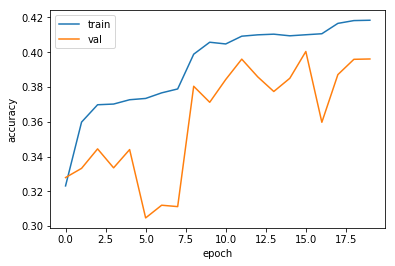

In [18]:
plt.plot(epochs, [x[3] for x in all_losses], label='train');
plt.plot(epochs, [x[4] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('accuracy');

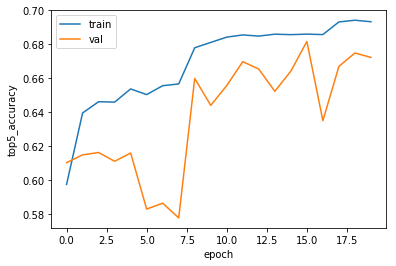

In [19]:
plt.plot(epochs, [x[5] for x in all_losses], label='train');
plt.plot(epochs, [x[6] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('top5_accuracy');

# Save

In [20]:
model.cpu();
torch.save(model.state_dict(), 'model_ternary_quantization.pytorch_state')